In [2]:
import os
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from matplotlib.colors import LinearSegmentedColormap

# --- Encontrar la raiz del proyecto (donde existe la carpeta "src") ---
CWD = Path.cwd()
PROJECT_ROOT = CWD
while PROJECT_ROOT != PROJECT_ROOT.parent and not (PROJECT_ROOT / "src").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

print("CWD:", CWD)
print("PROJECT_ROOT:", PROJECT_ROOT)

# --- Rutas ---
DATA_DIR_P2 = PROJECT_ROOT / "dataset" / "splits_p2"
MODELS_DIR  = PROJECT_ROOT / "models"
OUT_DIR     = PROJECT_ROOT / "results" / "final_test_p2"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# --- Paleta roja (rojo claro -> rojo -> rojo vino) ---
reds_wine = LinearSegmentedColormap.from_list(
    "reds_wine",
    ["#fde0dd", "#fb6a4a", "#7f0000"]  # claro -> rojo -> vino
)

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True


CWD: /home/olivia3/Machine-Learning-Project/src/results
PROJECT_ROOT: /home/olivia3/Machine-Learning-Project/src


In [3]:
train_path = DATA_DIR_P2 / "train.csv"
testF_path = DATA_DIR_P2 / "testF.csv"

train_df = pd.read_csv(train_path)
testF_df = pd.read_csv(testF_path)

TARGET_COL = "Fault Mode"

# Features: quitar Fault (constante 1 aquí) y el target
X_train = train_df.drop(columns=["Fault", TARGET_COL])
y_train = train_df[TARGET_COL]

X_testF = testF_df.drop(columns=["Fault", TARGET_COL])
y_testF = testF_df[TARGET_COL]

classes = sorted(y_train.unique().tolist())

print("Train:", train_df.shape, "classes:", sorted(y_train.unique()))
print("TestF:", testF_df.shape, "classes:", sorted(y_testF.unique()))
print("Features:", X_train.shape[1])


Train: (21700, 13) classes: [np.int64(1), np.int64(2), np.int64(3)]
TestF: (4650, 13) classes: [np.int64(1), np.int64(2), np.int64(3)]
Features: 11


In [4]:
def load_pipeline_params(meta_path: Path, allowed_prefixes):
    with open(meta_path, "r", encoding="utf-8") as f:
        meta = json.load(f)

    hp = meta.get("hyperparameters", {})

    # filtrar solo params del pipeline que nos interesan
    params = {k: v for k, v in hp.items() if any(k.startswith(p) for p in allowed_prefixes)}

    # compat: sklearn moderno no acepta multi_class
    params.pop("clf__multi_class", None)

    return params


In [5]:
def evaluate_and_save(model_name, pipe, X_tr, y_tr, X_te, y_te):
    # Entrenar
    pipe.fit(X_tr, y_tr)

    # Predecir
    y_pred = pipe.predict(X_te)

    # Reporte texto
    report = classification_report(y_te, y_pred, digits=4)
    print(f"\n==================== {model_name} — TEST FINAL (testF) ====================")
    print(report)

    # Guardar predicciones en CSV
    pred_df = pd.DataFrame({
        "y_true": y_te.values,
        "y_pred": y_pred
    })
    pred_csv_path = OUT_DIR / f"{model_name}_predictions_testF.csv"
    pred_df.to_csv(pred_csv_path, index=False)
    print("✅ Predicciones guardadas:", pred_csv_path)

    # --- Matriz de confusión (imagen) ---
    cm = confusion_matrix(y_te, y_pred, labels=classes)

    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(111)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax, cmap=reds_wine, colorbar=True, values_format="d")
    plt.title(f"{model_name} — Matriz de confusión (testF)")
    plt.tight_layout()

    cm_path = OUT_DIR / f"{model_name}_confusion_matrix_testF.png"
    plt.savefig(cm_path, dpi=200)
    plt.show()
    print("✅ Matriz de confusión guardada:", cm_path)

    # --- Gráfico: distribución Real vs Predicha ---
    true_counts = pd.Series(y_te).value_counts().reindex(classes, fill_value=0)
    pred_counts = pd.Series(y_pred).value_counts().reindex(classes, fill_value=0)

    x = np.arange(len(classes))
    width = 0.38

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar(x - width/2, true_counts.values, width, label="Real")
    ax.bar(x + width/2, pred_counts.values, width, label="Predicha")
    ax.set_xticks(x)
    ax.set_xticklabels(classes)
    ax.set_title(f"{model_name} — Distribución de clases (Real vs Predicha) en testF")
    ax.set_ylabel("Cantidad")
    ax.legend()
    plt.tight_layout()

    dist_path = OUT_DIR / f"{model_name}_class_distribution_testF.png"
    plt.savefig(dist_path, dpi=200)
    plt.show()
    print("✅ Gráfico distribución guardado:", dist_path)

    # --- Gráfico: errores por clase (cuántos falló por clase real) ---
    errors_by_class = (pred_df["y_true"] != pred_df["y_pred"]).groupby(pred_df["y_true"]).sum()
    errors_by_class = errors_by_class.reindex(classes, fill_value=0)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar(classes, errors_by_class.values)
    ax.set_title(f"{model_name} — Errores por clase real (testF)")
    ax.set_ylabel("Errores")
    plt.tight_layout()

    err_path = OUT_DIR / f"{model_name}_errors_by_class_testF.png"
    plt.savefig(err_path, dpi=200)
    plt.show()
    print("✅ Gráfico errores guardado:", err_path)

    return {
        "model": model_name,
        "report": report,
        "pred_csv": str(pred_csv_path),
        "cm_png": str(cm_path),
        "dist_png": str(dist_path),
        "err_png": str(err_path)
    }


In [6]:
LR_META = MODELS_DIR / "probl2_logistic_regression_20251217_090528_metadata.json"

lr_params = load_pipeline_params(
    LR_META,
    allowed_prefixes=["sampler__", "scaler__", "clf__"]
)

# Pipeline base (igual que antes)
lr_pipe = ImbPipeline(steps=[
    ("sampler", RandomUnderSampler(random_state=42)),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=5000, random_state=42))
])

lr_pipe.set_params(**lr_params)
lr_pipe


,steps,"[('sampler', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,sampling_strategy,'auto'
,random_state,42
,replacement,False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'l2'


/home/olivia3/Machine-Learning-Project/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/olivia3/Machine-Learning-Project/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l2 with l1_ratio=None. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(



==================== LogReg_P2 — TEST FINAL (testF) ====================
              precision    recall  f1-score   support

           1     0.9210    0.9365    0.9287      1544
           2     0.9994    1.0000    0.9997      1544
           3     0.9362    0.9200    0.9280      1562

    accuracy                         0.9520      4650
   macro avg     0.9522    0.9522    0.9521      4650
weighted avg     0.9521    0.9520    0.9520      4650

✅ Predicciones guardadas: /home/olivia3/Machine-Learning-Project/src/results/final_test_p2/LogReg_P2_predictions_testF.csv


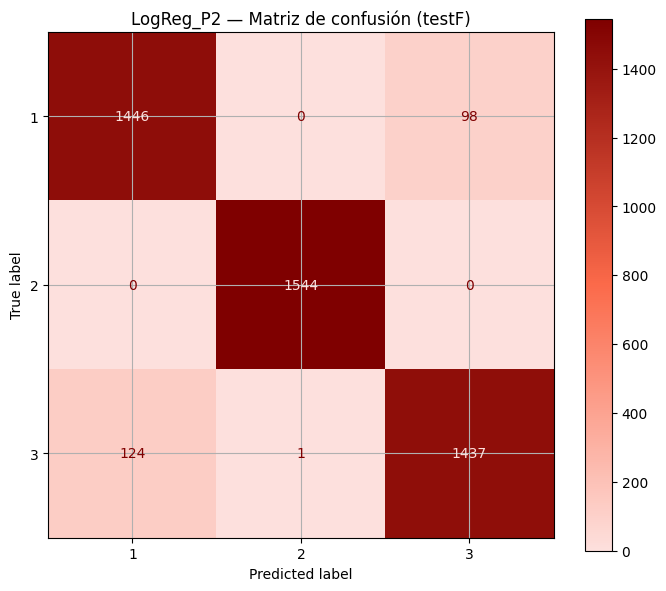

✅ Matriz de confusión guardada: /home/olivia3/Machine-Learning-Project/src/results/final_test_p2/LogReg_P2_confusion_matrix_testF.png


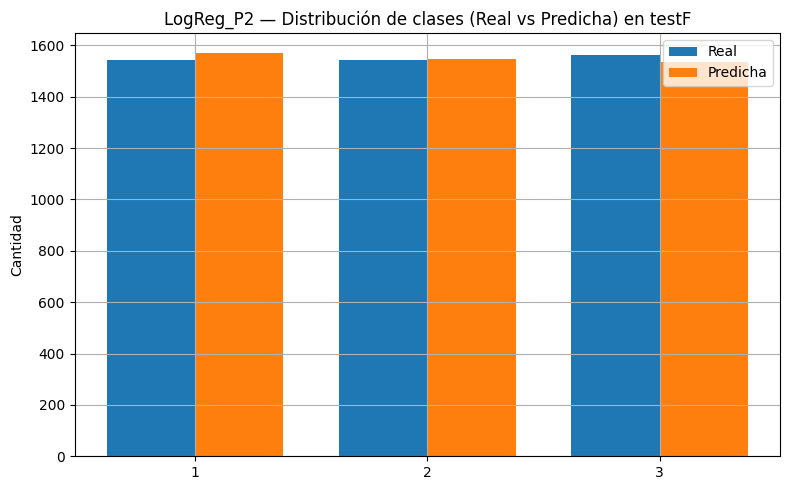

✅ Gráfico distribución guardado: /home/olivia3/Machine-Learning-Project/src/results/final_test_p2/LogReg_P2_class_distribution_testF.png


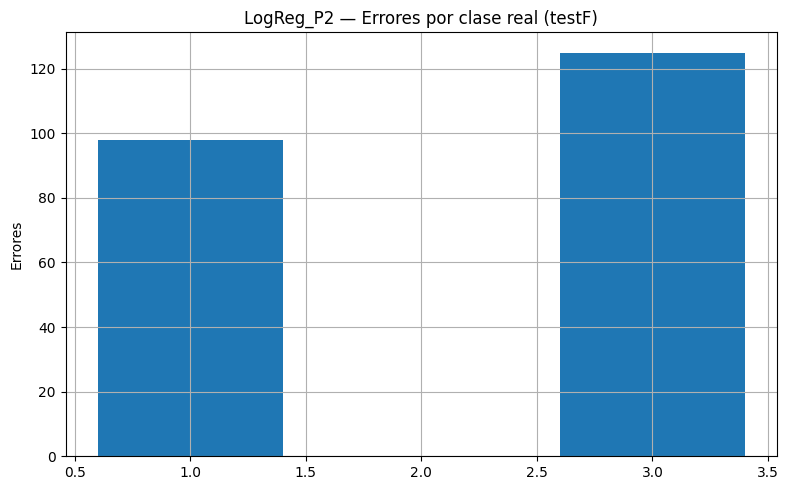

✅ Gráfico errores guardado: /home/olivia3/Machine-Learning-Project/src/results/final_test_p2/LogReg_P2_errors_by_class_testF.png


{'model': 'LogReg_P2',
 'report': '              precision    recall  f1-score   support\n\n           1     0.9210    0.9365    0.9287      1544\n           2     0.9994    1.0000    0.9997      1544\n           3     0.9362    0.9200    0.9280      1562\n\n    accuracy                         0.9520      4650\n   macro avg     0.9522    0.9522    0.9521      4650\nweighted avg     0.9521    0.9520    0.9520      4650\n',
 'pred_csv': '/home/olivia3/Machine-Learning-Project/src/results/final_test_p2/LogReg_P2_predictions_testF.csv',
 'cm_png': '/home/olivia3/Machine-Learning-Project/src/results/final_test_p2/LogReg_P2_confusion_matrix_testF.png',
 'dist_png': '/home/olivia3/Machine-Learning-Project/src/results/final_test_p2/LogReg_P2_class_distribution_testF.png',
 'err_png': '/home/olivia3/Machine-Learning-Project/src/results/final_test_p2/LogReg_P2_errors_by_class_testF.png'}

In [7]:
lr_out = evaluate_and_save("LogReg_P2", lr_pipe, X_train, y_train, X_testF, y_testF)
lr_out


In [9]:
SVM_META = MODELS_DIR / "probl2_svm_20251227_084344_metadata.json"

svm_params = load_pipeline_params(
    SVM_META,
    allowed_prefixes=["scaler__", "model__"]
)

svm_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVC())
])

svm_pipe.set_params(**svm_params)
svm_pipe



,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",195.60600539623996
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",0.04220067203463431



==================== SVM_P2 — TEST FINAL (testF) ====================
              precision    recall  f1-score   support

           1     0.9138    0.9339    0.9238      1544
           2     0.9981    0.9981    0.9981      1544
           3     0.9326    0.9123    0.9223      1562

    accuracy                         0.9480      4650
   macro avg     0.9482    0.9481    0.9481      4650
weighted avg     0.9481    0.9480    0.9480      4650

✅ Predicciones guardadas: /home/olivia3/Machine-Learning-Project/src/results/final_test_p2/SVM_P2_predictions_testF.csv


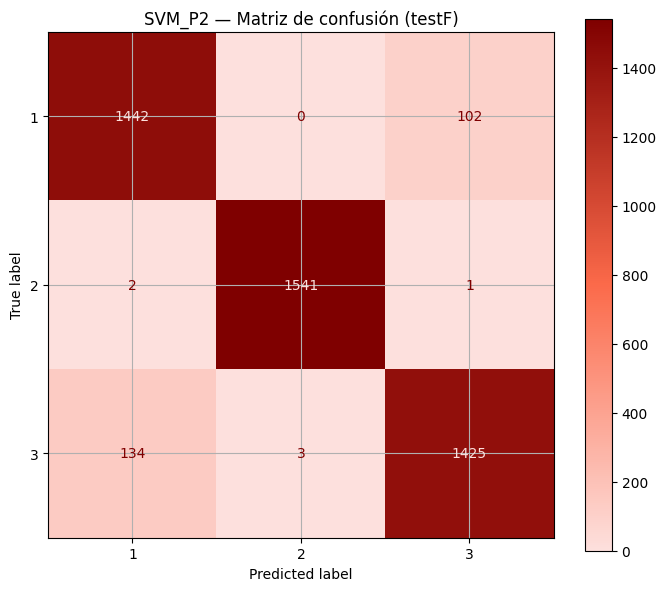

✅ Matriz de confusión guardada: /home/olivia3/Machine-Learning-Project/src/results/final_test_p2/SVM_P2_confusion_matrix_testF.png


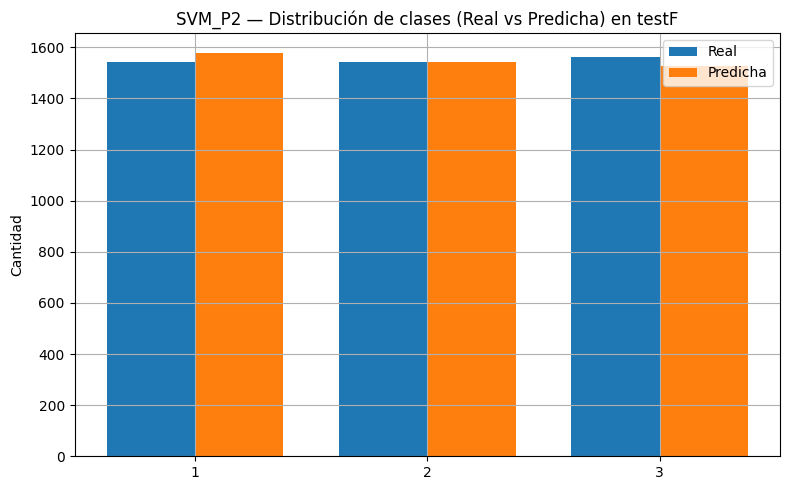

✅ Gráfico distribución guardado: /home/olivia3/Machine-Learning-Project/src/results/final_test_p2/SVM_P2_class_distribution_testF.png


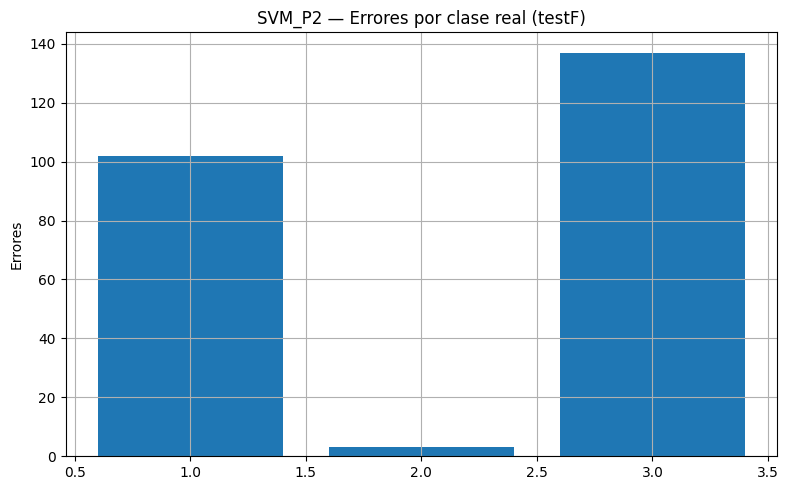

✅ Gráfico errores guardado: /home/olivia3/Machine-Learning-Project/src/results/final_test_p2/SVM_P2_errors_by_class_testF.png


{'model': 'SVM_P2',
 'report': '              precision    recall  f1-score   support\n\n           1     0.9138    0.9339    0.9238      1544\n           2     0.9981    0.9981    0.9981      1544\n           3     0.9326    0.9123    0.9223      1562\n\n    accuracy                         0.9480      4650\n   macro avg     0.9482    0.9481    0.9481      4650\nweighted avg     0.9481    0.9480    0.9480      4650\n',
 'pred_csv': '/home/olivia3/Machine-Learning-Project/src/results/final_test_p2/SVM_P2_predictions_testF.csv',
 'cm_png': '/home/olivia3/Machine-Learning-Project/src/results/final_test_p2/SVM_P2_confusion_matrix_testF.png',
 'dist_png': '/home/olivia3/Machine-Learning-Project/src/results/final_test_p2/SVM_P2_class_distribution_testF.png',
 'err_png': '/home/olivia3/Machine-Learning-Project/src/results/final_test_p2/SVM_P2_errors_by_class_testF.png'}

In [10]:
svm_out = evaluate_and_save("SVM_P2", svm_pipe, X_train, y_train, X_testF, y_testF)
svm_out


In [11]:
print("\n==================== RESUMEN FINAL — PROBLEMA 2 ====================")
print("Carpeta de salida:", OUT_DIR)
print("\nLogReg outputs:")
for k, v in lr_out.items():
    if k != "report":
        print(" -", k, ":", v)

print("\nSVM outputs:")
for k, v in svm_out.items():
    if k != "report":
        print(" -", k, ":", v)



==================== RESUMEN FINAL — PROBLEMA 2 ====================
Carpeta de salida: /home/olivia3/Machine-Learning-Project/src/results/final_test_p2

LogReg outputs:
 - model : LogReg_P2
 - pred_csv : /home/olivia3/Machine-Learning-Project/src/results/final_test_p2/LogReg_P2_predictions_testF.csv
 - cm_png : /home/olivia3/Machine-Learning-Project/src/results/final_test_p2/LogReg_P2_confusion_matrix_testF.png
 - dist_png : /home/olivia3/Machine-Learning-Project/src/results/final_test_p2/LogReg_P2_class_distribution_testF.png
 - err_png : /home/olivia3/Machine-Learning-Project/src/results/final_test_p2/LogReg_P2_errors_by_class_testF.png

SVM outputs:
 - model : SVM_P2
 - pred_csv : /home/olivia3/Machine-Learning-Project/src/results/final_test_p2/SVM_P2_predictions_testF.csv
 - cm_png : /home/olivia3/Machine-Learning-Project/src/results/final_test_p2/SVM_P2_confusion_matrix_testF.png
 - dist_png : /home/olivia3/Machine-Learning-Project/src/results/final_test_p2/SVM_P2_class_distribu